<a href="https://colab.research.google.com/github/NeyoxDrago/Algorithms-from-Scratch/blob/main/Regression_Algorithms_from_scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## for linear regression 
# https://towardsdatascience.com/understanding-linear-regression-eaaaed2d983e
# https://shuzhanfan.github.io/2018/07/understanding-mathematics-behind-linear-regression/

In [76]:
from sklearn.datasets import load_diabetes ,load_boston
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
from sklearn.preprocessing import StandardScaler

In [77]:
data = load_boston()
X = data['data']
target = data['target']
X = pd.DataFrame(X,columns=data['feature_names'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [78]:
target[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

In [184]:
class Regression(object):

  def __init__(self,
               X = None,
               Y = None,
               loss = "rmse",
               l1_penalty = 0.1,    ## l1 penlaty value
               l2_penalty = 0.1,    ## l2 penalty value
               iterations = 1000,   ## epochs to run loop 
               learning_rate = 0.1, ## learning
               weights = "random",
               **kwargs
               ):
    
    self.iterations = iterations
    self.learning_rate = learning_rate
    self.l1_penalty = l1_penalty
    self.l2_penalty = l2_penalty
    self.loss = loss
    self.X = X
    self.Y = Y

    self.losses = {"rmse":self.rmse,
                   "rmsle":self.rmsle}
    
    self.error_list = []

    if type(X) == pd.core.frame.DataFrame:
      self.X = self.X.values

    if type(Y) == pd.core.frame.DataFrame:
      self.Y = self.Y.values

    if weights == "random":
      self.W = np.random.rand(self.X.shape[1])
    elif weights == "zeros":
      self.W = np.zeros(self.X.shape[1])
    
    self.m = self.X.shape[0]

  def hypothesis(self, X_ ):
    pass

  def rmse(self, y_true, y_pred):
    return np.sum((y_pred - y_true)**2)

  def rmsle(self, y_true, y_pred):
    return np.sum((np.log(y_pred) - np.log(y_true))**2)

  def calc_gradient(self, X_, y_true):
    ## to be overriden
    pass

  def update(self,grad):
    self.W = self.W - self.learning_rate*grad

  def fit(self,verbose=None,eval_set=None,use_best_model = True, early_stopping_steps= 200):
    best_score = np.inf 
    best_iteration = 0

    step = 0

    for i in tqdm(range(self.iterations)):
      grad = self.calc_gradient(self.X,self.Y)
      self.update(grad)
      
      if eval_set != None:
        val_score = self.evaluate(*eval_set)
        if val_score < best_score:
          best_score = val_score
          best_weights = self.W
          best_iteration = i
          step = i

        if verbose != None and i % verbose == 0:
            print(f"Validation Data Score at iteration {i} : {val_score} at iteration : {best_iteration}")
        
        if (i-step) == early_stopping_steps:
          print("########")
          print(f"Score didn't improved in last {early_stopping_steps}.\nStopping iterations.")
          print(f"Best Score :: {best_score} --->> Achieved at iteration {step}")
          print("########")
          break

    if use_best_model and eval_set != None:
      self.W = best_weights
         
  
  def show_results(self):
    plt.plot(self.error_list)
    plt.xlabel("iterations")
    plt.ylabel('loss')
    plt.show()

  def evaluate(self,X,Y):
    y_pred = self.hypothesis(X)
    return self.losses[self.loss](Y,y_pred)/X.shape[0]
  
  def predict(self,X):
    return self.hypothesis(X)

In [208]:
class CustomLinearRegression(Regression):

  def __init__(self,**args):
    super(CustomLinearRegression,self).__init__(**args)
    
  def hypothesis(self, X_ ):
    return np.dot(X_ ,self.W)
  
  def calc_gradient(self, X_, y_true):
    y_pred = self.hypothesis(X_)
    e = self.losses[self.loss](y_true,y_pred)/X_.shape[0]
    self.error_list.append(e)
 
    grad = np.dot(X_.T, (y_pred - y_true))
    return grad/X_.shape[0]

class CustomLassoRegression(Regression):

  def __init__(self,**args):
    super(CustomLassoRegression,self).__init__(**args)
    
  def hypothesis(self, X_ ):
    return np.dot(X_ ,self.W) + self.l1_penalty*(np.sum(np.abs(self.W))/self.W.shape[0])

  def calc_gradient(self, X_, y_true):
    y_pred = self.hypothesis(X_)
    e = self.losses[self.loss](y_true,y_pred)/X_.shape[0]
    self.error_list.append(e)
 
    grad = np.dot(X_.T, (y_pred - y_true)) + self.l1_penalty*np.abs(self.W)
    return grad/X_.shape[0]

class CustomRidgeRegression(Regression):

  def __init__(self,**args):
    super(CustomRidgeRegression,self).__init__(**args)
    
  def hypothesis(self, X_ ):
    return np.dot(X_ ,self.W) + self.l2_penalty*(np.sum(self.W**2))
  
  def calc_gradient(self, X_, y_true):
    y_pred = self.hypothesis(X_)
    e = self.losses[self.loss](y_true,y_pred)/X_.shape[0]
    self.error_list.append(e)
 
    grad = np.dot(X_.T, (y_pred - y_true)) + 2*self.l2_penalty*self.W
    return grad/(2*X_.shape[0])


class CustomElasticNetRegression(Regression):

  def __init__(self,**args):
    super(CustomElasticNetRegression,self).__init__(**args)
    
  def hypothesis(self, X_ ):
    return np.dot(X_ ,self.W) + self.l2_penalty*(np.sum(self.W**2)) + self.l1_penalty*(np.sum(np.abs(self.W))/self.W.shape[0])
  
  def calc_gradient(self, X_, y_true):
    y_pred = self.hypothesis(X_)
    e = self.losses[self.loss](y_true,y_pred)/X_.shape[0]
    self.error_list.append(e)
 
    grad = np.dot(X_.T, (y_pred - y_true)) + 2*self.l2_penalty*self.W + self.l1_penalty*np.abs(self.W) 
    return grad/(2*X_.shape[0])


-- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- --
LINEAR Regression


Validation Data Score at iteration 0 : 588.4906248915566 at iteration : 0
Validation Data Score at iteration 100 : 569.8659537698481 at iteration : 68
Validation Data Score at iteration 200 : 571.5634488422993 at iteration : 68
########
Score didn't improved in last 200.
Stopping iterations.
Best Score :: 569.461435534342 --->> Achieved at iteration 68
########



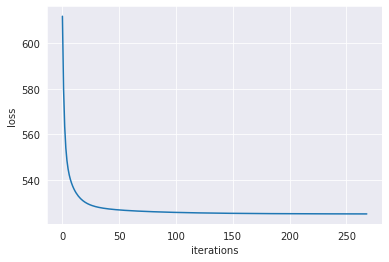



###############   Final Score Achieved ::: 569.461435534342


In [209]:
print("-- --"*50)
print('LINEAR Regression')
m = CustomLinearRegression(X=x_train,Y=y_train,
                          learning_rate = 0.05,
                          iterations=1000,
                          weights="random",
                          l1_penalty=0.2)

m.fit(verbose=100,eval_set=(x_test,y_test))
m.show_results()
print(f"\n\n###############   Final Score Achieved ::: {m.evaluate(x_test,y_test)}")

-- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- --
LASSO Regression


Validation Data Score at iteration 0 : 578.5401105469664 at iteration : 0
Validation Data Score at iteration 100 : 541.8058161511937 at iteration : 100
Validation Data Score at iteration 200 : 539.6286334687805 at iteration : 200
Validation Data Score at iteration 300 : 538.4671920137421 at iteration : 300
Validation Data Score at iteration 400 : 537.7937529552495 at iteration : 400
Validation Data Score at iteration 500 : 537.359467606198 at iteration : 500
Validation Data Score at iteration 600 : 537.069149579351 at iteration : 600
Validation Data Score at iteration 700 : 536.8719740073935 at iteration : 700
Validation Data Score at iteration 800 : 536.7368046019529 at iteration : 800
Validation Data Score at iteration 900 : 536.6435528621608 at iteration : 900



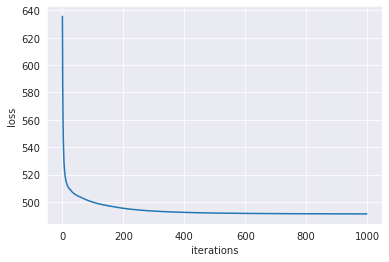



###############   Final Score Achieved ::: 536.579466641851


In [218]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,target,test_size=0.2,random_state=7)

print("-- --"*50)
print('LASSO Regression')
m = CustomLassoRegression(X=x_train,Y=y_train,
                          learning_rate = 0.05,
                          iterations=1000,
                          weights="random",
                          l1_penalty=0.5)

m.fit(verbose=100,eval_set=(x_test,y_test))
m.show_results()
print(f"\n\n###############   Final Score Achieved ::: {m.evaluate(x_test,y_test)}")
plt.show()

-- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- --
RIDGE Regression


Validation Data Score at iteration 0 : 513.504410705185 at iteration : 0
Validation Data Score at iteration 500 : 44.938880529731144 at iteration : 500
Validation Data Score at iteration 1000 : 34.94323958827369 at iteration : 1000
Validation Data Score at iteration 1500 : 34.3204486145984 at iteration : 1359
########
Score didn't improved in last 200.
Stopping iterations.
Best Score :: 34.270431797996906 --->> Achieved at iteration 1359
########



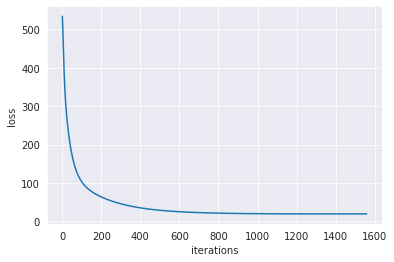



###############   Final Score Achieved ::: 34.270431797996906


In [219]:
print("-- --"*50)
print('RIDGE Regression')
m = CustomRidgeRegression(X=x_train,Y=y_train,
                          learning_rate = 0.05,
                          iterations=10000,
                          weights="random",
                          l2_penalty=0.5)

m.fit(verbose=500,eval_set=(x_test,y_test))
m.show_results()
print(f"\n\n###############   Final Score Achieved ::: {m.evaluate(x_test,y_test)}")

-- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- --
ElasticNet Regression


Validation Data Score at iteration 0 : 577.6075614434924 at iteration : 0
Validation Data Score at iteration 500 : 38.50575163868633 at iteration : 500
Validation Data Score at iteration 1000 : 34.453980162644 at iteration : 907
########
Score didn't improved in last 200.
Stopping iterations.
Best Score :: 34.368712969343484 --->> Achieved at iteration 907
########



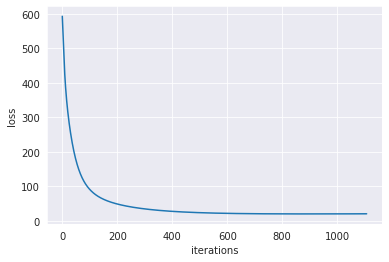



###############   Final Score Achieved ::: 34.368712969343484


In [230]:
print("-- --"*50)
print('ElasticNet Regression')
m = CustomElasticNetRegression(X=x_train,Y=y_train,
                               learning_rate = 0.05,
                               iterations=10000,
                               weights="zeros",
                               l1_penalty=0.5,
                               l2_penalty=0.5)

m.fit(verbose=500,eval_set=(x_test,y_test))
m.show_results()
print(f"\n\n###############   Final Score Achieved ::: {m.evaluate(x_test,y_test)}")